In [1]:
!pip install pytorch_lightning
!pip install pytorch_forecasting
!pip install pytorch_optimizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 52.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [2]:
# 1. 기본 라이브러리

import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

import copy
from pathlib import Path
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_lightning.tuner import Tuner
from lightning.pytorch import LightningModule,Trainer

## 학습

In [40]:
# 1. 데이터 준비
data = pd.read_csv("/content/date_integ_2.csv")
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.sort_values("date").reset_index(drop=True)

data = data.drop(columns=["export_restored"])

data["time_idx"] = np.arange(len(data))
data = data[data["export"] > 0]
data["log_export"] = np.log(data["export"])
data["group"] = "series"

In [41]:
# 2. train/test 분리
max_encoder_length = 50
max_prediction_length = 3
training_cutoff = data["time_idx"].max() - max_prediction_length
data["month"] = pd.to_datetime(data["date"]).dt.month
data["month_sin"] = np.sin(2 * np.pi * data["month"] / 12)
data["month_cos"] = np.cos(2 * np.pi * data["month"] / 12)
data["export_lag_1"] = data["export"].shift(1).bfill()
data["export_lag_3"] = data["export"].shift(3).bfill()
data["export_lag_6"] = data["export"].shift(6).bfill()
data["export_diff_3"] = data["export"] - data["export"].shift(3)
data["export_diff_3"] = data["export_diff_3"].bfill()

# TimeSeriesDataSet 구성
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="export",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=[
        "time_idx", "gdp_growth", "korea_lead", "brent_price",
        "exchange_rate", "gold_price", "gas_price", "usa_lead", "china_lead",
        "month_sin", "month_cos" ,"export_lag_1","export_lag_3", "export_lag_6", 'export_diff_3'
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["export", "log_export"],
    target_normalizer = None,#GroupNormalizer(groups=["group"], transformation="none"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# 테스트셋 (예측용)
testing = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)


In [42]:
# 3. DataLoader 구성
batch_size = 16
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


In [43]:
# 4. 최적 학습률 기반 모델 학습
from lightning.pytorch.callbacks import EarlyStopping
from pytorch_forecasting.metrics import RMSE

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=15,
    min_delta=1e-4,
    mode="min"
)

trainer = pl.Trainer(
    max_epochs=100,  # 필요에 따라 증가 가능
    callbacks=[early_stop],
    gradient_clip_val=0.9658579636307634,
    accelerator="cpu",
)

# 최적의 학습률
learning_rate = 0.002 #res.suggestion() 이전 단계에서 찾은 최적 학습률

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=32,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=32,
    loss=RMSE(),
    optimizer="Ranger",
)
trainer.fit(tft, train_dataloader, val_dataloaders=test_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 1.3 K  | train


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [47]:
# 5. 예측 수행
predictions = tft.predict(
    test_dataloader,
    mode="raw",
    return_x=True
)

raw_predictions = predictions.output

x = predictions.x

# 예측값 예시 확인
print("예측값 샘플:", raw_predictions["prediction"])
print("실제값 샘플:", x["decoder_target"])

예측값 샘플: tensor([[[0.7326],
         [0.7112],
         [0.9539]]])
실제값 샘플: tensor([[1.1144, 0.8968, 0.9341]])


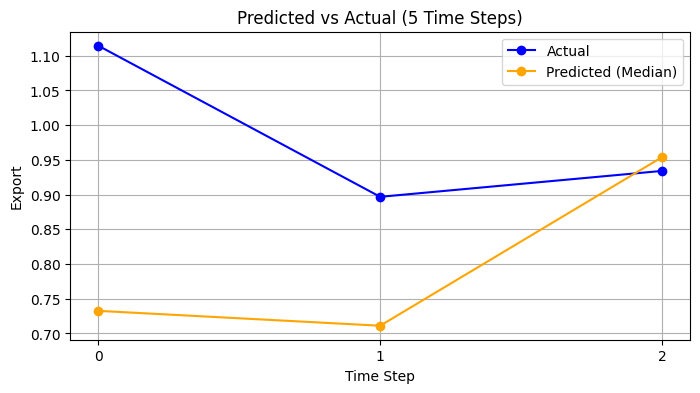

In [45]:
import matplotlib.pyplot as plt

idx = 0  # 테스트 샘플 인덱스

# 실제값: shape = (5,)
actual = x["decoder_target"][idx].detach().cpu().numpy()

# 예측값: shape = (5, 7) → 분위수 중 중앙값(3번째 index) 사용
predicted = raw_predictions["prediction"][idx][:, 0].detach().cpu().numpy()

# 시점 인덱스 (예: [0, 1, 2, 3, 4])
time_steps = list(range(len(actual)))

# 시각화
plt.figure(figsize=(8, 4))
plt.plot(time_steps, actual, 'o-', label="Actual", color="blue")
plt.plot(time_steps, predicted, 'o-', label="Predicted (Median)", color="orange")

plt.title("Predicted vs Actual (5 Time Steps)")
plt.xlabel("Time Step")
plt.ylabel("Export")
plt.xticks(time_steps)
plt.legend()
plt.grid(True)
plt.show()


In [34]:
x = predictions.x  # return_x=True로 받아온 입력값들

# 예측한 시점이 언제인지 확인
print(x["decoder_time_idx"][0])

tensor([177, 178, 179])


In [35]:
# 중복 제거된 time_idx ↔ date 매핑 테이블 생성
time_idx_to_date = data[["time_idx", "date"]].drop_duplicates().sort_values("time_idx")
# 예측한 시점 리스트로 변환
future_time_idx = x["decoder_time_idx"][0].tolist()

# 예측 시점에 해당하는 날짜 확인
future_dates = time_idx_to_date[time_idx_to_date["time_idx"].isin(future_time_idx)]

print(future_dates)

     time_idx       date
177       177 2024-10-01
178       178 2024-11-01
179       179 2024-12-01


In [46]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 예측 수행
predictions = tft.predict(
    test_dataloader,
    mode="raw",
    return_x=True
)

# 예측값과 실제값 저장용 리스트
y_true = []
y_pred = []

# 샘플 수 만큼 반복
for idx in range(len(raw_predictions["prediction"])):
    # 실제값
    actual = x["decoder_target"][idx].detach().cpu().numpy()

    # 예측값 (중앙값만 선택)
    predicted = raw_predictions["prediction"][idx][:, 0].detach().cpu().numpy()

    # 리스트에 저장
    y_true.extend(actual)
    y_pred.extend(predicted)

# 정확도 지표 출력
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")


MAE : 0.1957
RMSE : 0.2454
